In [ ]:
import os
import math
import cv2
import numpy as np
import pandas as pd
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

In [ ]:
def download_from_gdrive(file_id, file_name):
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget \
  --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  'https://docs.google.com/uc?export=download&id=$file_id' -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$file_id" \
  -O $file_name && rm -rf /tmp/cookies.txt
  clear_output(wait=True)

  print("{} downloaded!".format(file_name))

In [ ]:
# download dogs_data.zip file from google drive
download_from_gdrive("1RnjRqFo_36KGjzTbB_a9qL3SdglQPPnN", "dogs_data.zip")

# download dogs.zip file from google drive
# download_from_gdrive("1sM5Qm_ouTcvmLBf-GM2AJgwPAoGvXhhZ", "dogs.zip")

# download dog_website_memos file
download_from_gdrive("1QF_xiqjT424KClAHYHpiJAFZPJx7sDOU", "dog_website_memos.csv")


dog_website_memos.csv downloaded!


In [ ]:
!unzip -qq dogs_data.zip

In [ ]:
!cat /content/dog_data/data_dictionary.txt

dogs.csv - one row for every dog taken into custody since 1/1/2017.
-fields:
—-"AnimalID" - public facing unique id
--"AnimalInternal-ID" - internal unique id - USE THIS to link to the other tables (dogs_photos.csv and dogs_website_memos.csv)
--"AnimalName" 
--"AnimalType" - always "Dog"
--"AnimalSex" - Male, Female or Unknown
--"AnimalCurrentWeightPounds" - decimal weight in pounds. NOTE: data quality of this field is mediocre at best. Staff are good about recording at least one weight around the time of intake but not as diligent about recording a weight prior to outcome.
--"AnimalDOB" -  DOB formatted as YYYYMMDD
--"AnimalBreed" - concatenation of primary and secondary breed fields delimited by " /". 
--"AnimalColor" - concatenation of primary and secondary colors fields delimited by " /". 
--"AnimalPattern" - animal pattern NOTE: not often populated for dogs. More often used for cats


dogs_photos.csv - one row for every photo uploaded to a dogs profile.
-fields:
--"AnimalInternal-

In [ ]:
dogs = pd.read_csv('/content/dog_data/dogs.csv')
dogs.head(100)

,AnimalID,AnimalInternal-ID,AnimalName,AnimalType,AnimalSex,AnimalCurrentWeightPounds,AnimalDOB,AnimalBreed,AnimalColor,AnimalPattern
0,45628,1444011,Emma,Dog,Female,53.3,20150306,"Retriever, Yellow Labrador /Mix",Blond /None,NaN
1,45629,1444014,Rizzoli,Dog,Female,4.7,20161222,Mixed Breed (Small),Tan /None,NaN
2,45630,1444017,Isles,Dog,Female,3.1,20161222,Mixed Breed (Small),White /None,NaN
3,45631,1444020,Cory,Dog,Male,4.7,20161222,Mixed Breed (Small),Sable /None,NaN
4,45632,1444023,Topanga,Dog,Female,8.0,20161222,Mixed Breed (Small),Tan /None,NaN
...,...,...,...,...,...,...,...,...,...,...
95,45846,1473990,Right,Dog,Male,30.0,20161117,"Terrier, Pit Bull",Tan/None,NaN
96,45847,1473992,Lockhart 7,Dog,Female,4.6,20161117,"Terrier, Pit Bull",Tan /None,NaN
97,45848,1474007,Hamilton,Dog,Male,74.7,20151208,"Shepherd, German",Sable /Black,NaN
98,45849,1474197,Ruby Rose,Dog,Female,19.5,20161030,Pointer,White /Black,NaN


In [ ]:
dogs.isnull().sum()

AnimalID                         0
AnimalInternal-ID                0
AnimalName                       0
AnimalType                       0
AnimalSex                       50
AnimalCurrentWeightPounds        0
AnimalDOB                        0
AnimalBreed                     29
AnimalColor                     42
AnimalPattern                16062
dtype: int64

In [ ]:
weightThreshold = 200
currYear = 2021

def preprocess_color(s):
  lst = s.split('/')
  res = ""
  if lst[0]=="" or lst[0].strip()=="0":
    if (len(lst) > 1):
      res = lst[1].strip()
    else:
      res = "Unknown"
  res = lst[0].strip()
  if res=="None" or res=="" or res=="0":
    res = "Unknown"
  return res

dogs_new = dogs.copy()
dogs_new.drop(["AnimalPattern", "AnimalType"], axis=1, inplace=True)
dogs_new.dropna(inplace=True)
dogs_new = dogs_new[dogs_new['AnimalSex'] != "Unknown"]
dogs_new = dogs_new[dogs['AnimalCurrentWeightPounds'] < weightThreshold]
dogs_new["Age"] = currYear - dogs.AnimalDOB.astype(str).apply(lambda x : int(x[:4]))
dogs_new["Breed"] = dogs_new.AnimalBreed.apply(lambda x : x.split('/')[0].split(',')[0])
dogs_new["isMixed"] = dogs_new.AnimalBreed.str.contains('Mix')
dogs_new["Color"] = dogs_new.AnimalColor.apply(preprocess_color)
dogs_new.drop("AnimalDOB 	AnimalBreed 	AnimalColor".split(), axis=1, inplace=True)
dogs_new.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,AnimalID,AnimalInternal-ID,AnimalCurrentWeightPounds,Age
count,16885.000000,1.688500e+04,16885.000000,16885.000000
mean,67738.477228,1.181844e+07,26.029870,4.131122
std,13467.907920,8.905617e+06,23.381409,2.714432
min,45628.000000,1.444011e+06,0.000000,1.000000
25%,55443.000000,2.885279e+06,6.630000,2.000000
50%,66865.000000,9.562973e+06,17.400000,4.000000
75%,79217.000000,1.941123e+07,45.000000,5.000000
max,91299.000000,3.160458e+07,150.000000,23.000000


In [ ]:
#dogs_new.to_csv("processed_dogs.csv", index=False)
dogs_new.nunique()

AnimalID                     16885
AnimalInternal-ID            16885
AnimalName                    9030
AnimalSex                        2
AnimalCurrentWeightPounds     1302
Age                             23
Breed                          140
isMixed                          2
Color                           22
dtype: int64

Text(0.5, 1.0, 'Dog Gender Distribution')

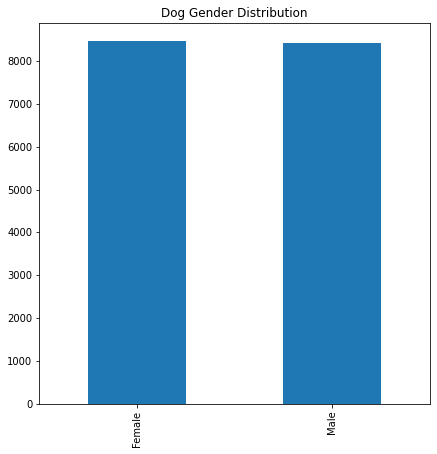

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
dogs_new.AnimalSex.value_counts().plot(kind='bar', ax=ax)
ax.set_title("Dog Gender Distribution")

(0.0, 151.0)

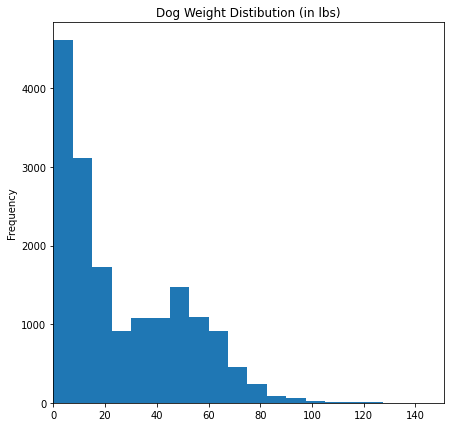

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
dogs_new.AnimalCurrentWeightPounds.plot(kind='hist', ax=ax, bins=20)
ax.set_title("Dog Weight Distibution (in lbs)")
ax.set_xlim((0, dogs_new.AnimalCurrentWeightPounds.max()+1))

(0.0, 24.0)

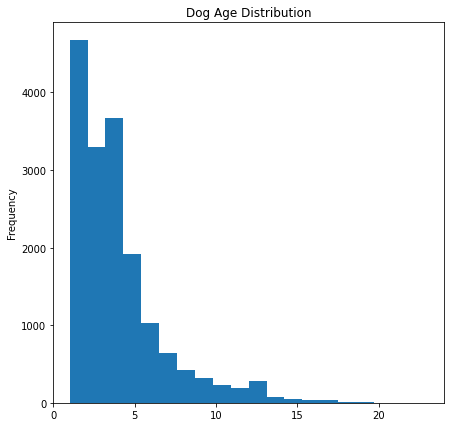

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
dogs_new.Age.plot(kind='hist', ax=ax, bins=20)
ax.set_title("Dog Age Distribution")
ax.set_xlim((0, dogs_new.Age.max()+1))

Text(0.5, 1.0, 'IsMixedBreed')

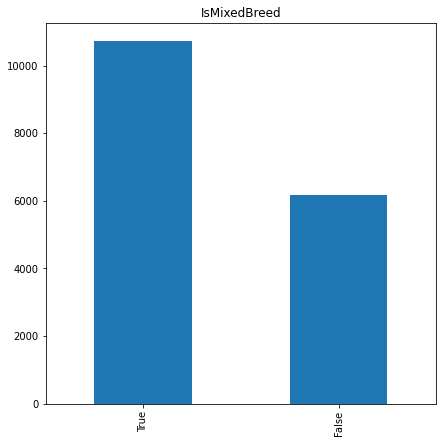

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
dogs_new.isMixed.value_counts().plot(kind='bar', ax=ax)
ax.set_title("IsMixedBreed")

Text(0.5, 1.0, 'Dog Color')

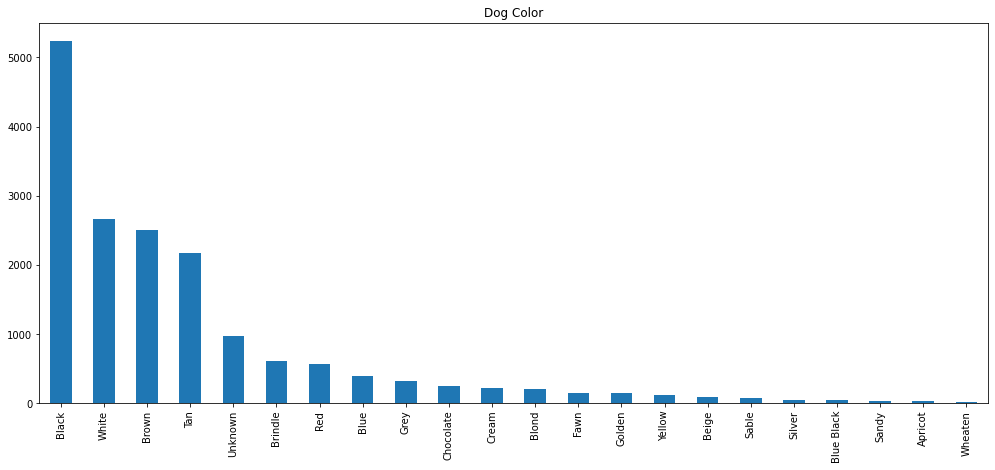

In [ ]:
fig, ax = plt.subplots(figsize=(17, 7))
dogs_new.Color.value_counts().plot(kind='bar', ax=ax)
ax.set_title("Dog Color")

In [ ]:
dog_photos = pd.read_csv("/content/dog_data/dogs_photos.csv")
dog_photos

,AnimalInternal-ID,PhotoUrl
0,1444011,https://www.shelterluv.com/sites/default/files...
1,1444011,https://www.shelterluv.com/sites/default/files...
2,1444011,https://www.shelterluv.com/sites/default/files...
3,1444011,https://www.shelterluv.com/sites/default/files...
4,1444011,https://www.shelterluv.com/sites/default/files...
...,...,...
65985,31598600,https://www.shelterluv.com/sites/default/files...
65986,31604583,https://www.shelterluv.com/sites/default/files...
65987,31604583,https://www.shelterluv.com/sites/default/files...
65988,31604583,https://www.shelterluv.com/sites/default/files...


In [ ]:
data = dogs_new.set_index('AnimalInternal-ID').join(dog_photos.set_index('AnimalInternal-ID'), on='AnimalInternal-ID', how='inner')
data.isnull().any()

AnimalID                     False
AnimalName                   False
AnimalSex                    False
AnimalCurrentWeightPounds    False
Age                          False
Breed                        False
isMixed                      False
Color                        False
PhotoUrl                     False
dtype: bool

In [ ]:
data.nunique()

AnimalID                     14838
AnimalName                    8194
AnimalSex                        2
AnimalCurrentWeightPounds     1236
Age                             23
Breed                          137
isMixed                          2
Color                           22
PhotoUrl                     65651
dtype: int64

In [ ]:
data.to_csv("data_merged.csv", index=True)

In [ ]:
#download_from_gdrive("1QF_xiqjT424KClAHYHpiJAFZPJx7sDOU", "dog_website_memos.csv")
dog_memos = pd.read_csv("/content/dog_website_memos.csv")
dog_memos

,AnimalInternal-ID,MemoText
0,1468738,"""Meet Cornell, he's a social butterfly deluxe ..."
1,1468727,"""Shaya is a puppy with potential extraordinair..."
2,1468736,"""Would you like to love good Luna? She's a won..."
3,1470308,"""Stanley is a seasoned elder statesman who sti..."
4,1479031,"""Khaleesi is a purebred American Bulldog that..."
...,...,...
6482,28651257,"""The name says it all! Caboom is such a happy ..."
6483,31126346,"""Isis is a very loyal and affectionate pup who..."
6484,27260685,"""Introducing Sweet Pea, a lovely four year-old..."
6485,30788520,"""Jack Sparrow is a sweet and easy-going boy. H..."


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 28.5 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 3.3 MB 45.9 MB/s 
     |████████████████████████████████| 636 kB 57.2 MB/s 
     |████████████████████████████████| 895 kB 61.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import pipeline
model = pipeline('question-answering')

def talk(question, context):
  return model(question=question, context=context)['answer']

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
unique_ids = set(data.index)
def get_context(animal_id):
  if animal_id not in unique_ids:
    print("Invalid id")
    return ""
  details = data.loc[24643580].iloc[0]
  context = f"My name is {details.AnimalName}. I am {details.Age} years old. My color is {details.Color}. My weight is {details.AnimalCurrentWeightPounds}. My gender or sex is {details.AnimalSex}. My breed is {details.Breed}."
  extras = [
            "I have the prettiest little puppy face.",
            "I am sweet.",
            "I have stunning grey eyes that will win you over instantly, and have the cutest floppy ears.",
            "I am still learning what my crate is for, and working hard to master house training.",
            "I love crinkly stuffed toys.",
            "I am very low key and relaxed.",
            "I love to be held, and will cuddle in your lap to take a snooze."]
  context += ' '.join(extras)
  return context

get_context(24643580)

'My name is Angelina. I am 4 years old. My color is Red. My weight is 61.0. My gender or sex is Female. My breed is Terrier.I have the prettiest little puppy face. I am sweet. I have stunning grey eyes that will win you over instantly, and have the cutest floppy ears. I am still learning what my crate is for, and working hard to master house training. I love crinkly stuffed toys. I am very low key and relaxed. I love to be held, and will cuddle in your lap to take a snooze.'

In [ ]:
def chatbot(to=24643580):
  context = get_context(to)
  q = input()
  while (q != ""):
    print("               Reply->", talk(q, context))
    q = input()

chatbot()

Hi WHat is your name
               Reply-> Angelina
How old are you
               Reply-> 4 years old
WHat do you love
               Reply-> Angelina
Which breed
               Reply-> Terrier
are you house trained
               Reply-> working hard to master house training
are you pretty
               Reply-> Angelina

